# Techniques of High Performance Computing - Assignment 3

**Name: John Duffy**

**Student Number: 19154676**

## Import Libraries Common to Question 1 & 2

In [1]:
# Import libraries common to Questions 1 & 2.

import numpy as np
import pyopencl as cl

from scipy.sparse.linalg import LinearOperator, cg

#from scipy.sparse import dia_matrix, csr_matrix, eye, rand
#from scipy.sparse.linalg import LinearOperator, cg

# Question 1: Investigating Splitting Schemes

## Jacobi Iteration

### Program Description

### Program Structure

#### The init Method

#### The matvec Method

#### The OpenCL Kernel

The OpenCL kernel takes the following as parameters:

- **const int m** The number of rows of the sparse matrix
- **const int n** The number of columns of the sparse matrix
- **__global const double \*data** A pointer to the sparse matrix data array stored in device global memory
- **__global const double \*indices** A pointer to the sparse matrix indices array stored in device global memory
- **__global const double \*indptr** A pointer to the sparse matrix indices pointer array stored in device global memory
- **__global const double \*u** A pointer to the input vector array stored in global memory
- **__global double \*v** A pointer to the output vector stored in global memory

### Correctness Testing

### Performance Testing

## Gauss-Seidel Iteration

### Program Description

### Program Structure

### Correctness Testing

### Performance Testing



## Jacobi Iteration

In [2]:
# Define the OpenCL kernel string used in the class DiscreteLaplacian. It is defined here outside
# of the class for readability, and also so that it may be developed/debugged externally and
# easily included here as part of a build system.

kernel_string = """

__kernel void discrete_laplacian(const int m, __global const float *u, __global float *v)
{
    // Retrieve the row and column indexes from the global id's.
    
    int r = get_global_id(0);
    int c = get_global_id(1);
    
    // Don't change the boundary conditions.
    
    if (r == 0 || r == m - 1 || c == 0 || c == m - 1) {
        v[m * r + c] = u[m * r + c];
        return;
    } 
    
    // Implement the averaging formula for the interior points.

    v[m * r + c] = (u[m * (r + 1) + c] + u[m * (r - 1) + c] + u[m * r + (c + 1)] + u[m * r + (c - 1)]) / 4.0f;
}

"""


# Define the class DiscreteLaplacian.

class DiscreteLaplacian(LinearOperator):
    """
    """
    
    def __init__(self, m):
        """
        """
        
        # Store the size m as an instance variable for access by class methods.
        
        self._m = m
        
        
        # Attributes required to be declared by LinearOperator.
        
        self.shape = (m * m, m * m)
        
        self.dytpe = np.float32
        

        # Create a GPU specific context and command queue.
        
        self._ctx = cl.Context(dev_type = cl.device_type.GPU)
        
        self._queue = cl.CommandQueue(self._ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)
 

        # Create input and output buffers, u and v. Note: u is READ_ONLY and v is WRITE_ONLY.
 
        self._u = cl.Buffer(self._ctx, cl.mem_flags.READ_ONLY, size = np.dtype(np.float32).itemsize * m * m)
        
        self._v = cl.Buffer(self._ctx, cl.mem_flags.WRITE_ONLY, size = np.dtype(np.float32).itemsize * m * m)
        

        # Build the kernel.
        
        self._kernel = cl.Program(self._ctx, kernel_string).build().discrete_laplacian

    
    def _matvec(self, u):
        """
        """

        # Use mapped input to efficiently copy the input vector u to the device.
        
        mapped_input, _ = cl.enqueue_map_buffer(self._queue, self._u, cl.map_flags.WRITE, 0, self._m * self._m, np.float32)
        
        with mapped_input.base:
            mapped_input[:] = u.astype(np.float32)


        # Run the kernel across all grid points in parallel using a global workspace m x m. 
            
        self._kernel(self._queue, (self._m, self._m), None, np.int32(self._m), self._u, self._v)


        # Create an output vector v and copy the output from the device.
                     
        v = np.zeros((self._m, self._m), dtype=np.float32)

        cl.enqueue_copy(self._queue, v, self._v)
                     

        # Return v as the correct datatype.
            
        return v.astype(np.float32)

### Correctness Testing

In [69]:
# Test the class DiscreteLaplacian.

M = 5

# Generate test data with boundary conditions as per Question 1.

u = np.full((M, M), 0.0, dtype=np.float32)

u[:, 0] = 0.0
u[0, :] = 0.0
u[:, M-1] = 0.0
u[M-1, :] = 1.0

print(u)

laplacian = DiscreteLaplacian(M)

v = laplacian(np.ascontiguousarray(u.flatten())).reshape(M, M)

print(v)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1.]]
[[0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.25 0.25 0.25 0.  ]
 [1.   1.   1.   1.   1.  ]]


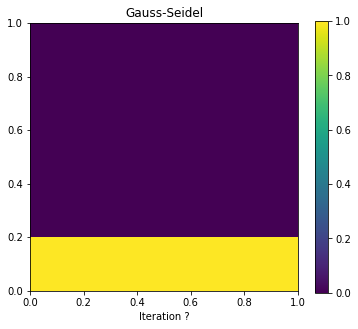

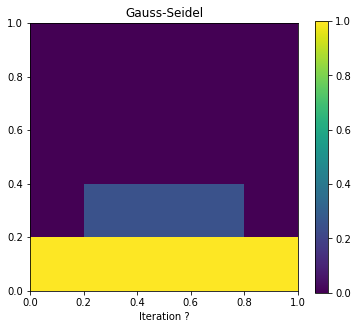

In [70]:
%matplotlib inline

from matplotlib import pyplot as plt

def plot(z):
    """
    """
    plt.figure(figsize=(6, 5))
    plt.imshow(z, extent=[0, 1, 0, 1], origin='upper')
    plt.colorbar()
    plt.title('Gauss-Seidel')
    plt.xlabel('Iteration ?')
    plt.show()
    
def plot_side_by_side(v_upwards, v_downwards):
    """
    """
    plt.figure(figsize=(13, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(v_upwards, extent=[0, 1, 0, 1])
    plt.colorbar()
    plt.title('Upwards')
    plt.xlabel('Iteration ?')

    plt.subplot(1, 2, 2)
    plt.imshow(v_downwards, extent=[0, 1, 0, 1])
    plt.colorbar()
    plt.title('Downwards')
    plt.xlabel('Iteration ?')

    plt.tight_layout()
    plt.show()


plot(u)
plot(v)

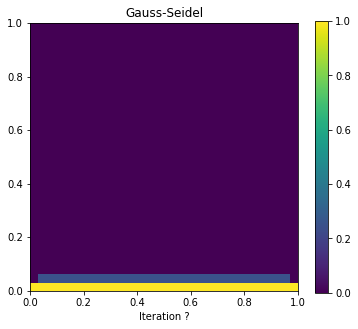

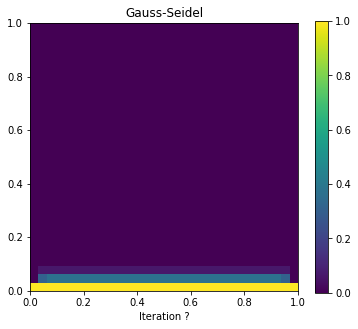

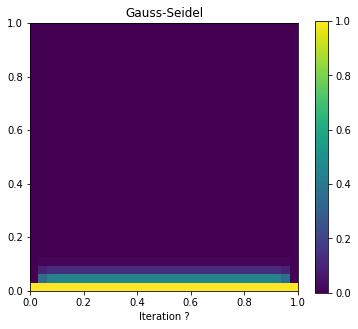

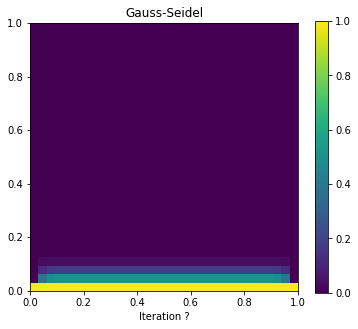

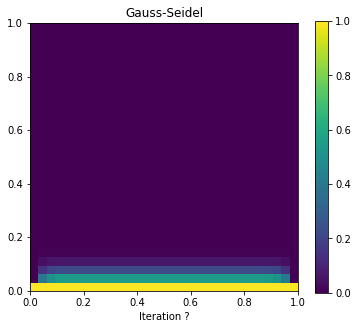

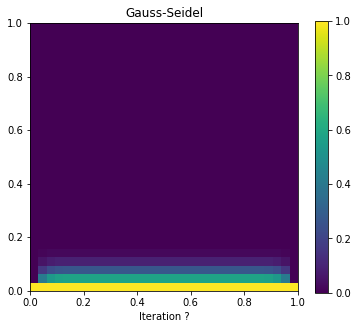

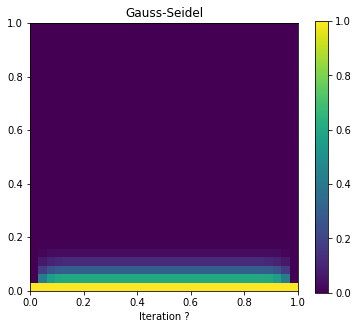

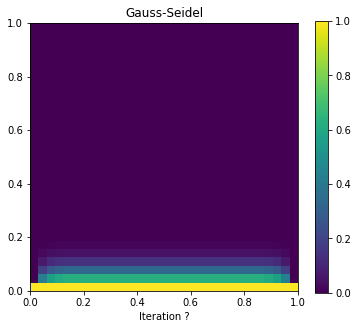

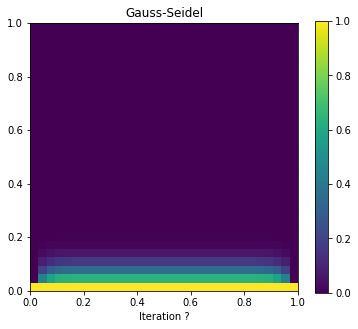

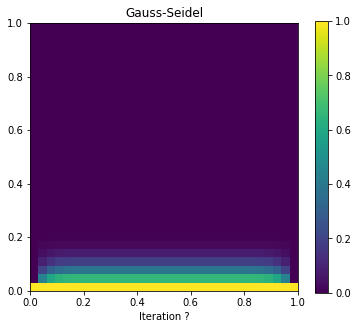

In [71]:
# Repeated call...

M = 32

u = np.full((M, M), 0.0, dtype=np.float32)

u[:, 0] = 0.0
u[0, :] = 0.0
u[:, M-1] = 0.0
u[M-1, :] = 1.0

laplacian = DiscreteLaplacian(M)

for _ in range(10):
    v = laplacian(u.flatten()).reshape(M, M)
    plot(v)
    u = v

## Gauss-Seidel Iteration: Numba Implemenation

In [72]:
from numba import njit

@njit
def gauss_seidel_upwards_update_row(m, u, v, row):
    """
    This function...
    """
    for col in range(1, m - 1):
        v[row, col] = (v[row + 1, col] + u[row - 1, col] + u[row, col + 1] + u[row, col - 1]) / 4.0

@njit
def gauss_seidel_downwards_update_row(m, u, v, row):
    """
    This function...
    """
    for col in range(1, m - 1):
        v[row, col] = (u[row + 1, col] + v[row - 1, col] + u[row, col + 1] + u[row, col - 1]) / 4.0

In [73]:
@njit
def gauss_seidel_iteration(m, u, v, direction='upwards'):
    """
    This function...
    """
    #v = np.copy(u)

    if (direction == 'upwards'):
        for row in range(m - 2, 0, -1):
            gauss_seidel_upwards_update_row(m, u, v, row)
            
    if (direction == 'downwards'):
        for row in range(1, m - 1):
            gauss_seidel_downwards_update_row(m, u, v, row)

    return v

### Correctness Testing

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1.]]
[[0.       0.       0.       0.       0.      ]
 [0.       0.015625 0.015625 0.015625 0.      ]
 [0.       0.0625   0.0625   0.0625   0.      ]
 [0.       0.25     0.25     0.25     0.      ]
 [1.       1.       1.       1.       1.      ]]


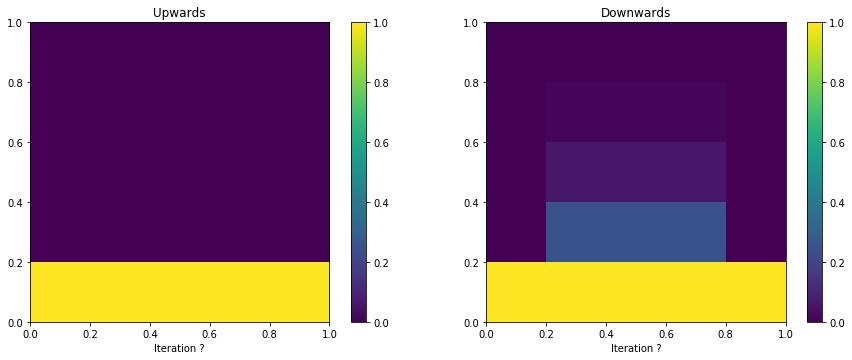

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1.]]
[[0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.25 0.25 0.25 0.  ]
 [1.   1.   1.   1.   1.  ]]


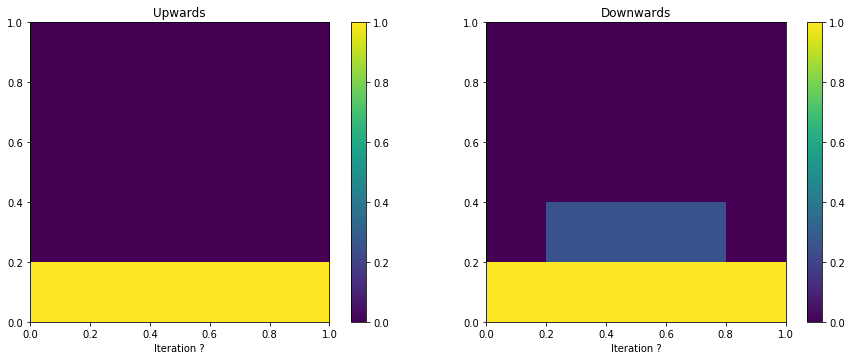

In [74]:
M = 5

u = np.full((M, M), 0.0, dtype=np.float32)

u[:, 0] = 0.0
u[0, :] = 0.0
u[:, M-1] = 0.0
u[M-1, :] = 1.0

v = np.copy(u)

gauss_seidel_iteration(M, u, v, 'upwards')

print(u)
print(v)

plot_side_by_side(u, v)

gauss_seidel_iteration(M, u, v, 'downwards')

print(u)
print(v)

plot_side_by_side(u, v)

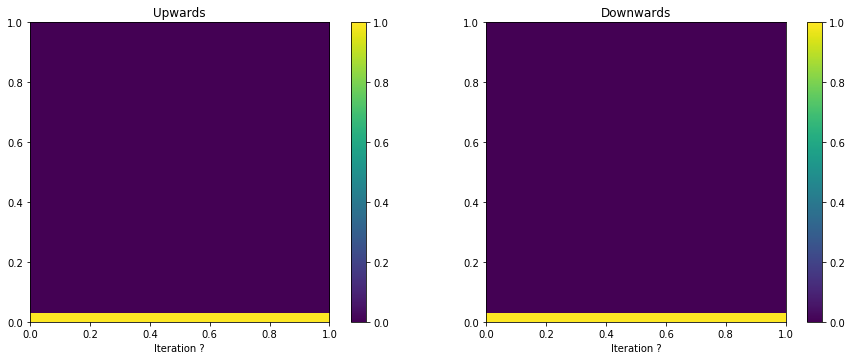

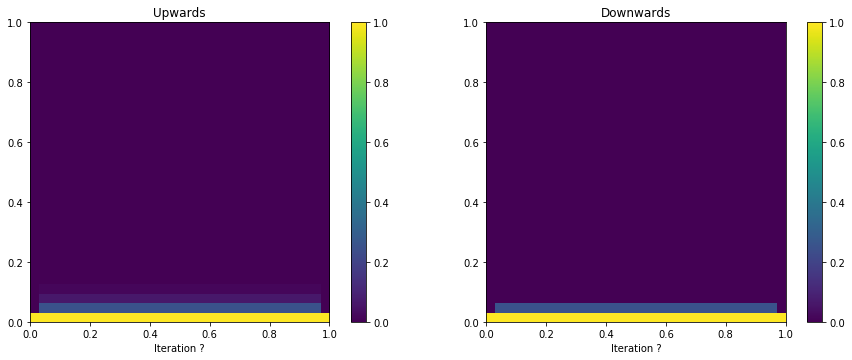

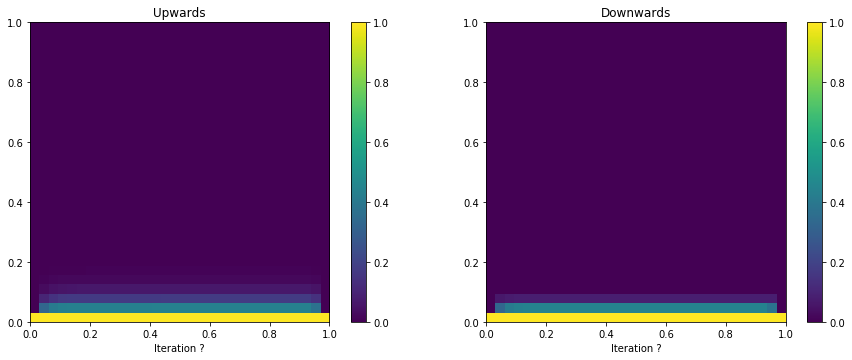

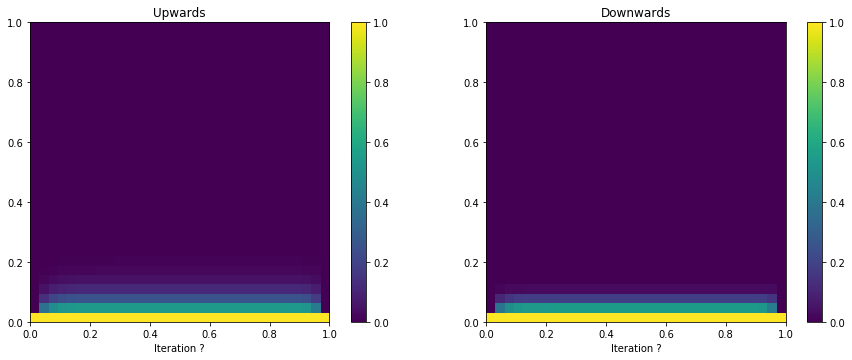

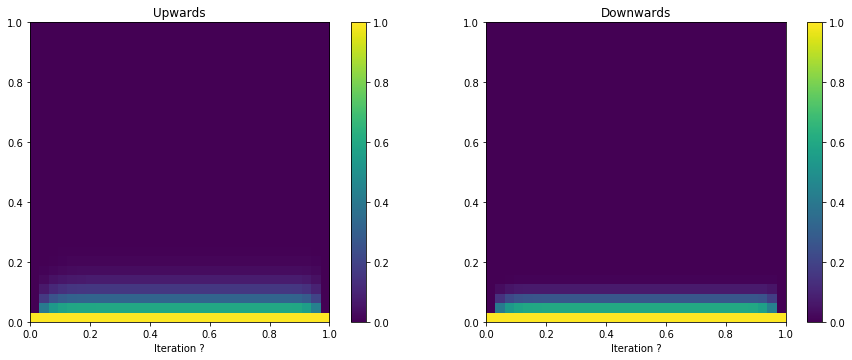

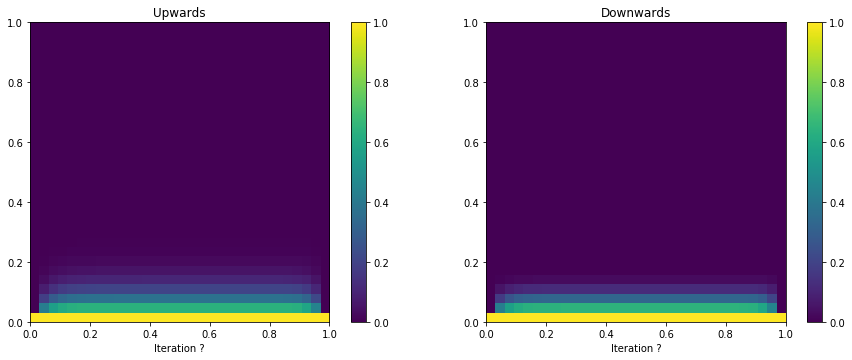

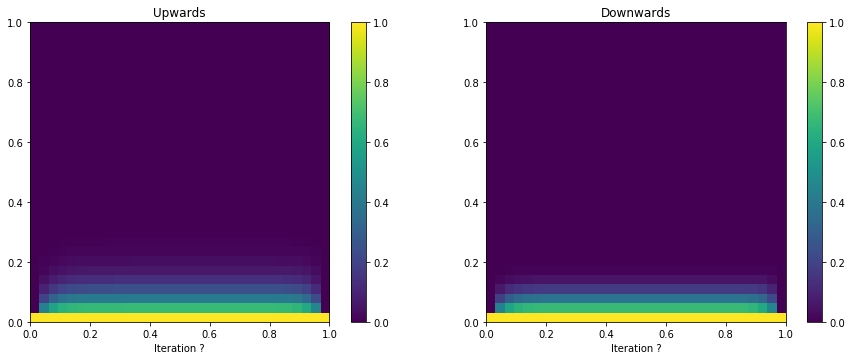

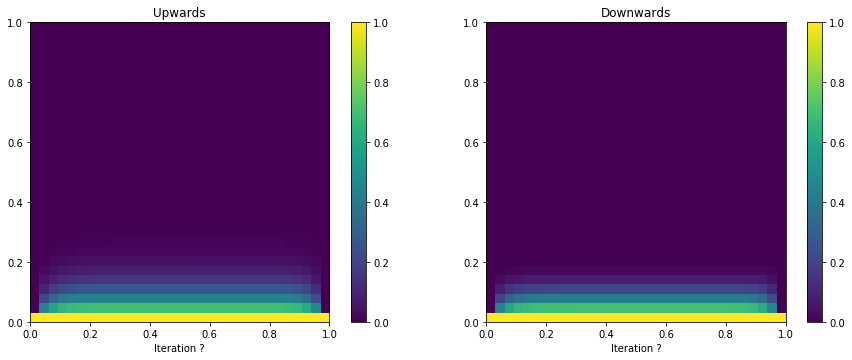

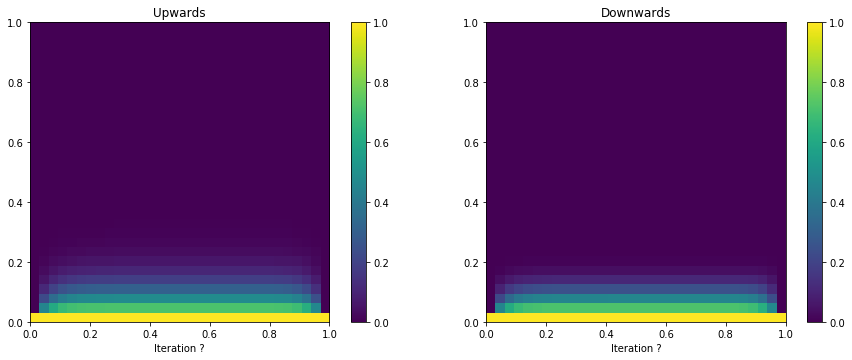

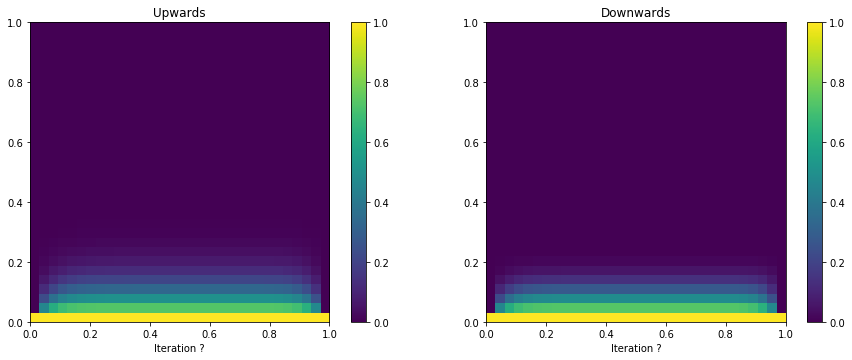

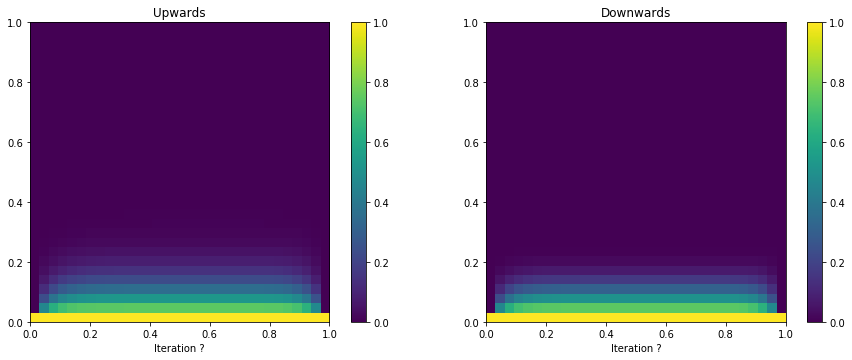

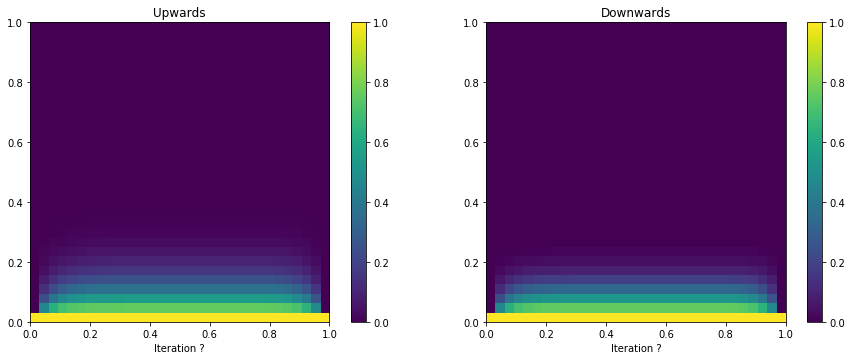

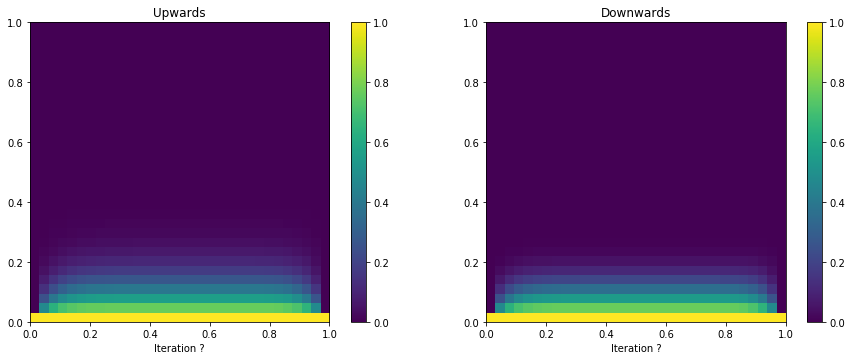

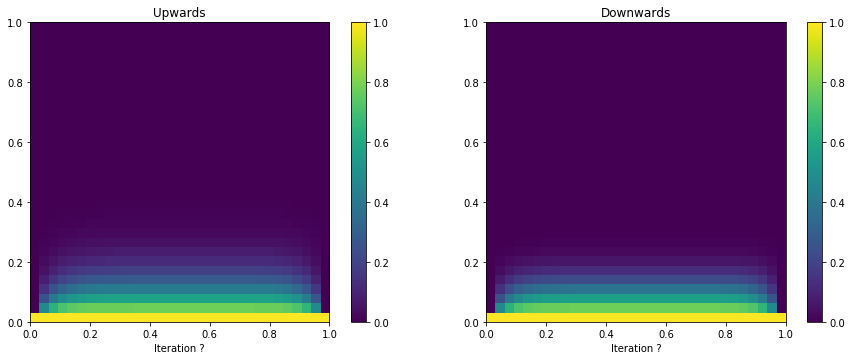

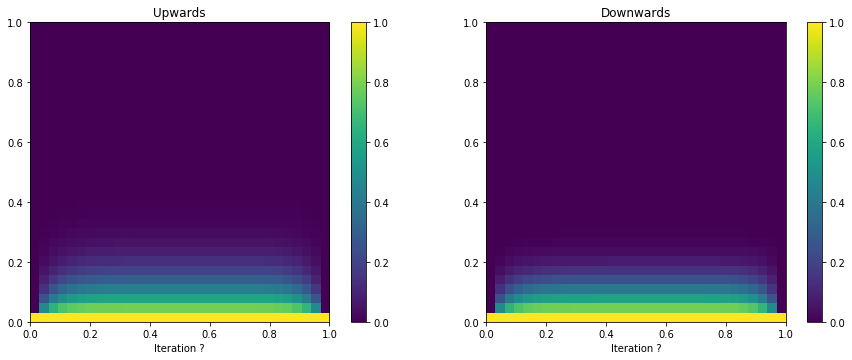

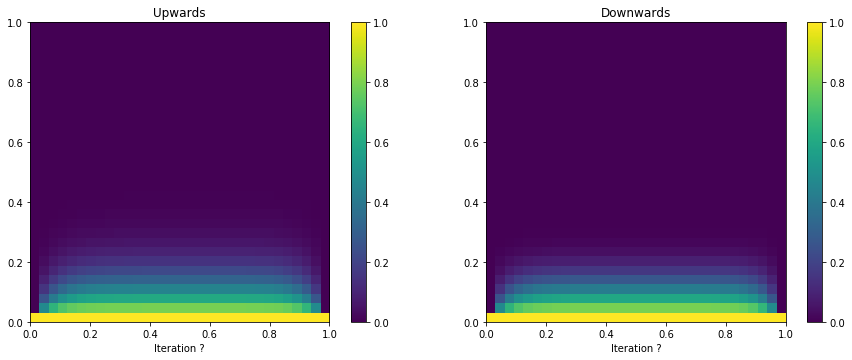

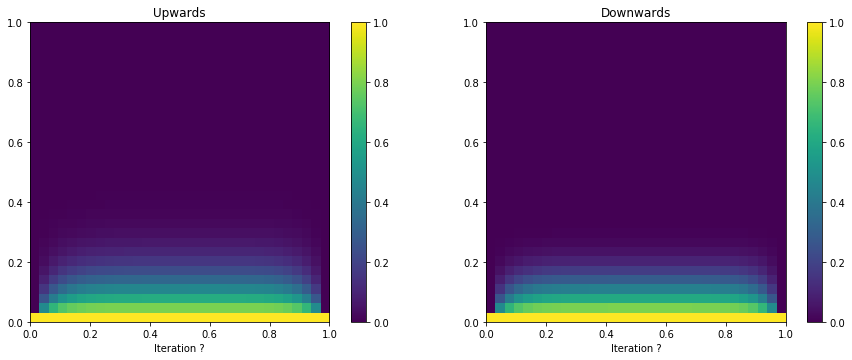

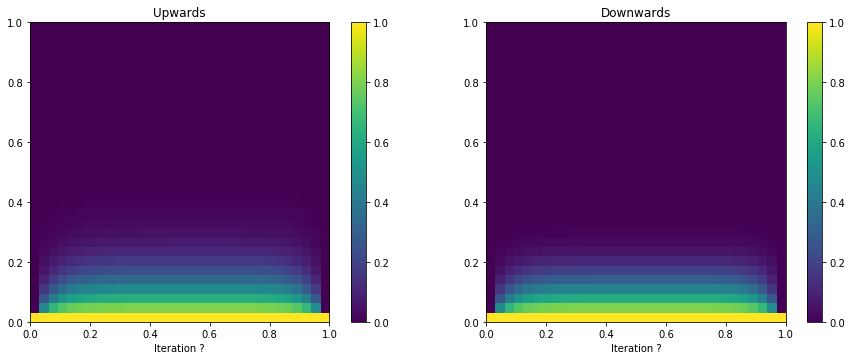

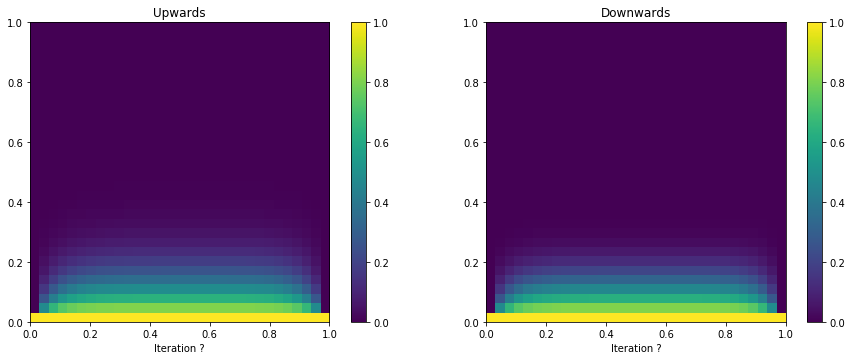

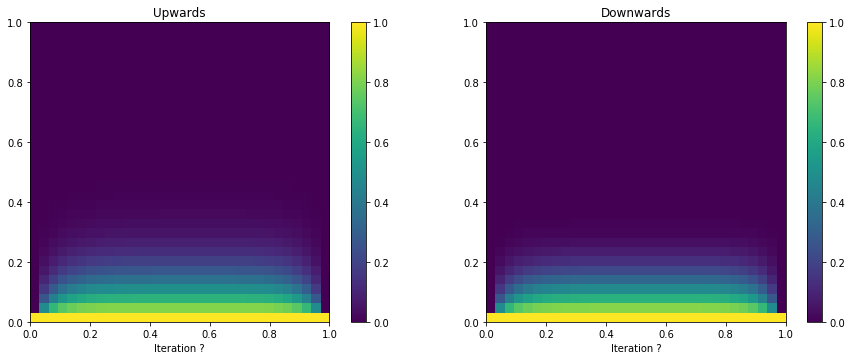

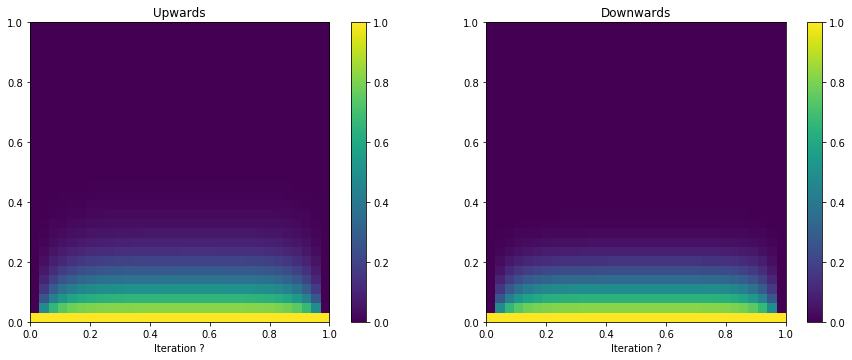

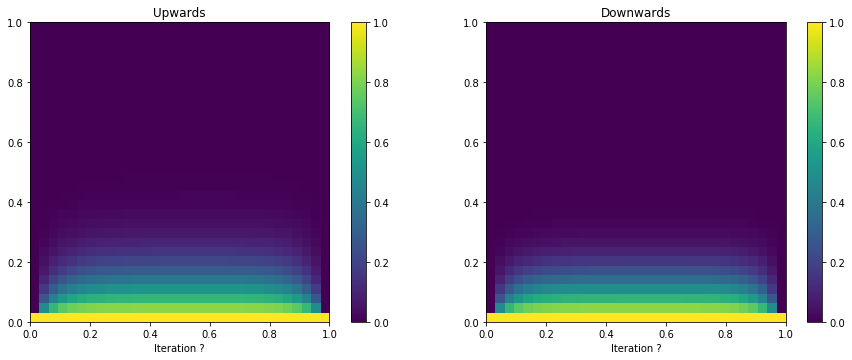

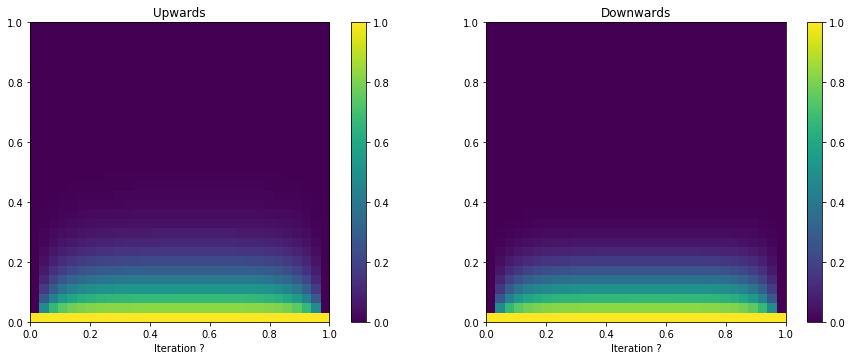

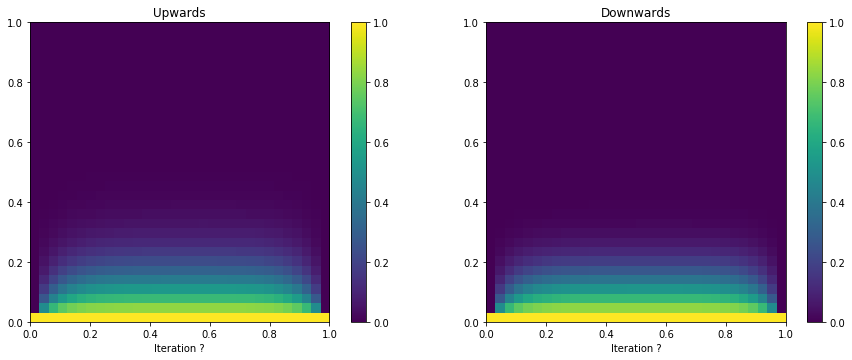

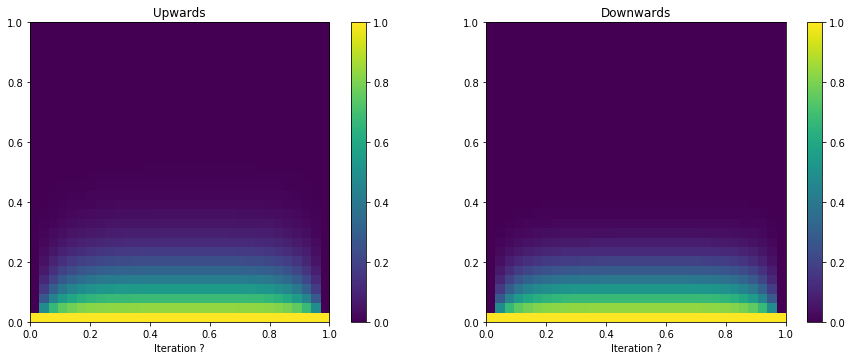

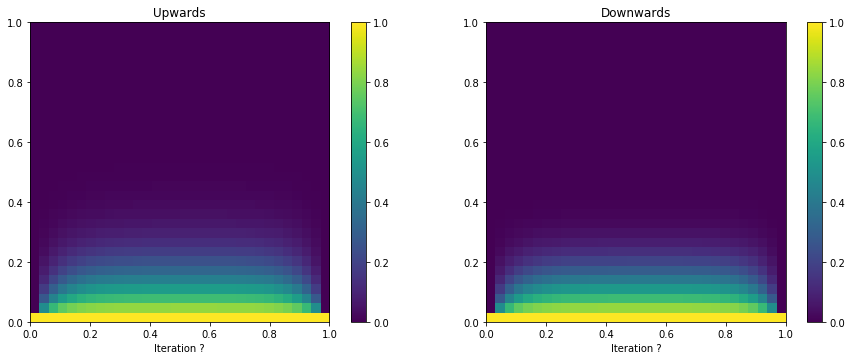

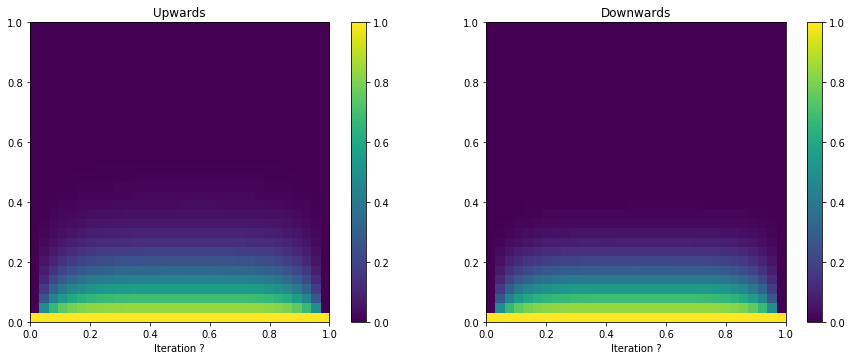

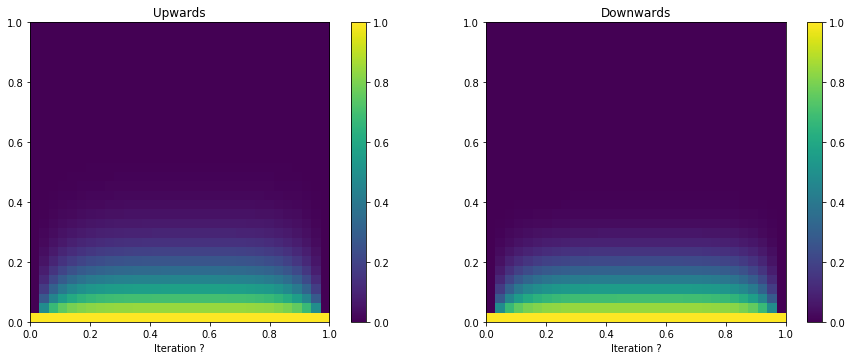

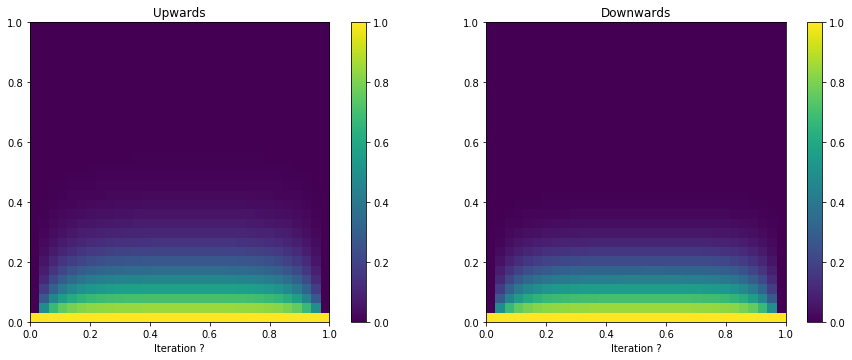

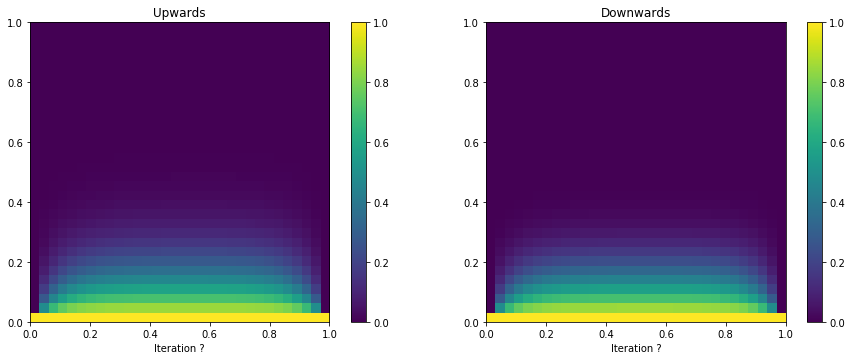

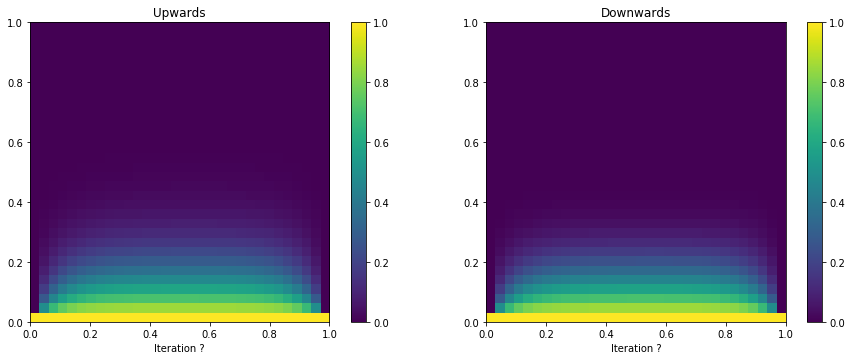

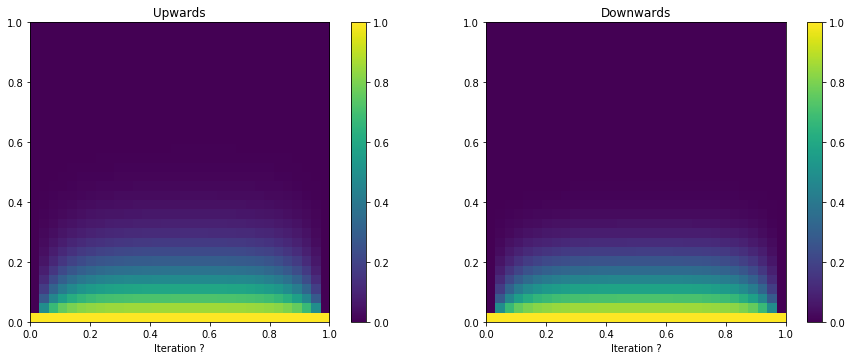

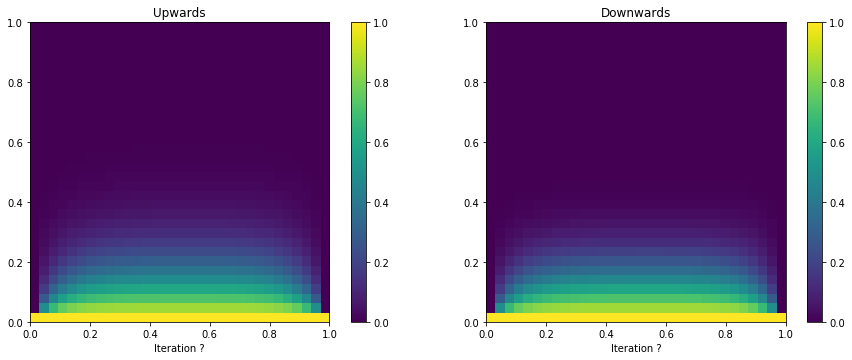

In [66]:
# Repeated calls to gauss_seidel_upwards and downwards...

M = 32

u = np.full((M, M), 0.0, dtype=np.float32)

u[:, 0] = 0.0
u[0, :] = 0.0
u[:, M-1] = 0.0
u[M-1, :] = 1.0

u_upwards = np.copy(u)
v_upwards = np.copy(u)

u_downwards = np.copy(u)
v_downwards = np.copy(u)

plot_side_by_side(u_upwards, u_downwards)

for _ in range(32):
    gauss_seidel_iteration(M, u_upwards, v_upwards, 'upwards')
    gauss_seidel_iteration(M, u_downwards, v_downwards, 'downwards')
    plot_side_by_side(v_upwards, v_downwards)
    u_upwards = v_upwards
    u_downwards = v_downwards

## Gauss-Seidel Iteration: Relaxed with OpenCL

# Question 2: Preconditioned Iterative Solvers